# Introduction to `SEDBuilder`

### Welcome! This notebook hopefully provides a sufficient and simple introduction to what `SEDBuilder` does and how to use it. Enjoy, and let me know if you have any questions - Zephyr

### Important: `SEDBuilder` currently only works for objects in the 2MASS survey (includes almost all stars), because it uses the 2MASS ID as a unique object identifier. 

In [1]:
# You don't have to use autoreload, it's just useful for me while I'm still developing the package.
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function #ONLY NECESSARY IN PYTHON 2
import SEDBuilder.spectra  # Very occasionally astroquery.gaia (loaded by SEDBuilder) doesn't import correctly. 
                            # If so just re-run this.
                            # As well as SEDBuilder you'll need to have numpy, astropy, and astroquery installed 
                            # (and possibly at some point matplotlib).
import numpy as np
import astropy
import os

# optional, for plotting
import matplotlib.pyplot as plt
%matplotlib inline

/Users/Emily/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


# Examples of using `SEDBuilder`

### Let's use v410 x-ray 1 as an example. 
### We'll idenitfy it by one (of many) of the names Simbad can use to recognise it.


In [2]:
v410xray1 = '[SS94] V410 X-ray 1' # (could also use the coordinates, ra+dec, or any other Simbad-compatible name)

# getInfo()
### Pulls simple data about this star from Simbad (+Gaia) and puts it into a Python dictionary.

In [3]:
starInfo=SEDBuilder.spectra.getInfo(name=v410xray1)
# If you'd rather use a coordinate call, getInfo(ra=RA,dec=DEC) will return data for nearest 2MASS object to the specified RA and dec.

# And let's have a look at that data (returned as a dictionary)
print('\n _______INFORMATION ABOUT THE STAR')
for key in starInfo.keys():
    print(key,': ',starInfo[key])
# For this particular star, Gaia has no recorded radius, luminosity or dust-reddening coefficient (Ag). 
# (However, they have calculated that info for many stars, so worth it is still worth checking.)


 _______INFORMATION ABOUT THE STAR
RadiusSource :  
SimbadName :  IRAS F04147+2822
AgSource :  
StellarType :  M3.7
Teff :  4315.1724
Ag :  -1
StellarTypeSource :  Herczeg+ 2014
Luminosity :  -1
LuminositySource :  
Distance :  129.03225806451613
CoordSource :  Gaia Collaboration 2018
Radius :  -1
RA :  04 17 49.6578
2MASSID :  J04174965+2829362
TeffSource :  Gaia Collaboration 2018
DistanceSource :  Gaia Collaboration 2018
DEC :  +28 29 36.325
ObjectType :  TTau*


# getSED()
### Finds the photometric data points for this object that are tabulated in VizieR and NASA's IRSA database, as well as supplementary metadata of the type returned by getInfo().
### It returns the photometric data points in an astropy table, with the supplementary metadata in that table's table.meta attribute.
### It should take a few seconds to run.
### If getBibcodes=True, it will be slower (~1 minute).


In [5]:
table=SEDBuilder.spectra.getSED(name=v410xray1,getBibcodes=True)

# Again let's have a look at that data
print('\n _______MAIN TABLE OF FLUXS:')
print(table)
print('\n _______SUPPLEMENTARY INFORMATION') # almost exactly the same as what is returned by getInfo()
for key in table.meta.keys():
    print(key,': ',table.meta[key])


 _______MAIN TABLE OF FLUXS:
    lambda         flux         error      ...  telescope        bibcode      
------------- ------------- -------------- ... ----------- -------------------
 4.445103e-07 1.1447982e-08   4.539717e-09 ...       2MASS 2008AJ....136..735L
4.6832557e-07    7.7418e-09  3.0638927e-09 ...        POSS 2008AJ....136..735L
 4.775549e-07 4.5514597e-09    7.76116e-10 ...  Pan-STARRS 2016arXiv161205560C
 5.049655e-07 1.3059328e-08   9.412128e-10 ...        Gaia 2018A&A...616A...1G
 6.129955e-07  7.233273e-09 1.03788686e-10 ...  Pan-STARRS 2016arXiv161205560C
  6.23053e-07  4.250441e-08  1.3137728e-09 ...        Gaia 2018A&A...616A...1G
 6.404372e-07 4.7908156e-08  1.8504982e-08 ...        POSS 2008AJ....136..735L
6.7346116e-07 5.5230966e-08  1.0583179e-09 ...        Gaia 2017A&A...600L...4A
6.7346116e-07 5.5230966e-08            0.0 ...        Gaia 2016A&A...595A...1G
6.7346116e-07 5.5230966e-08            0.0 ...        Gaia 2017yCat.1340....0Z
          ...         

### We try our best to identify which telescope each observation is from, but sometimes it's not clearly recorded (or it's just a one-off observation and not from a recognizable survey). You can add new telescopes, or link certain papers with telescopes, by hardcoding them in the getSED function, or asking me to do so.


# Simple Plot

### Let's quickly plot this to see what the SED looks like. The default plotting function takes a matplotlib axes object (if this sounds unfamiliar I really recommend learning about and using them!) and plots all the data. 

### Specifically it highlights data from particular telescopes, which can be given as an optional argument for the plotting function, here we use the default telescopes (and colours).

### Upper limits are plotted as open triangles and all units are SI

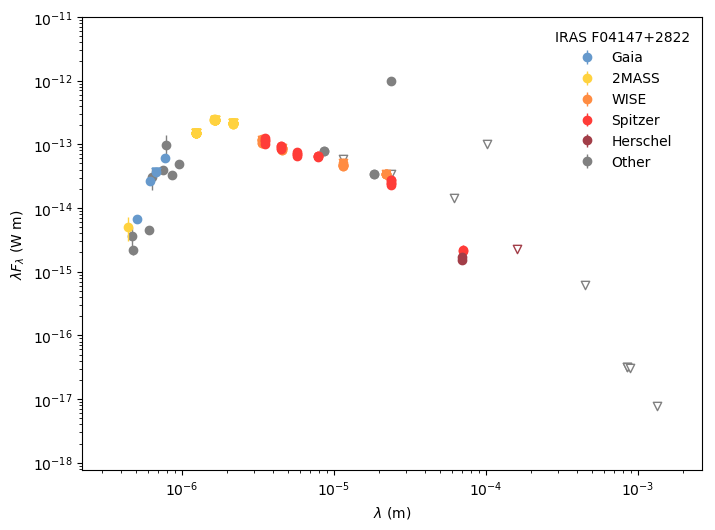

In [6]:
exampleFig=plt.figure(figsize=(8,6)) # just making sure our plot is a good size

examplePlot=plt.gca() # initiallising a matplotlib axes object
SEDBuilder.spectra.plotSED(examplePlot,table) # plotting the data
plt.show() # and displaying it

### For a lot of users, this may be all you need (if you just want an object's SED), but below there's details about how you can do even more by saving the photometric data points to a file.

# Saving to file and adding new data

### Great. Now we could just use the data like this, in an astropy table. However if we save it to file we can do even more, as we can start appending data from other sources (right now we're limited to just those that are easily sourceable and machine-readable online).

### First let's just save it to file:

In [6]:
# Finds data repository in the install location of the SEDBuilder package.
# (though of course you can specify any repository as saveDirectory instead.)
SEDDir = os.path.abspath(SEDBuilder.__file__)
SEDDir = "/".join(SEDDir.split("/")[:-2])
saveDirectory=SEDDir+'/spectraData'

# Writes data to a file (identified by the star's 2MASS Id) in that directory.
# THIS IS CURRENTLY SET TO OVERWRITE EXISTING DATA!
# Overwrite behavior:
# overwrite = -1 : overwrites nothing
# overwrite = 0  [default]: overwrites data only if there's a more recent data point available online.
# overwrite = 1  : overwrites everything
table = SEDBuilder.spectra.getSED(name=v410xray1,saveDir=saveDirectory,overwrite=0)

# Let's have a look at that data.
print('\n _______MAIN TABLE OF FLUXS:')
print(table)
print('\n _______SUPPLEMENTARY INFORMATION')
for key in table.meta.keys():
    print(key,': ',table.meta[key])


 Data file for this star already exists
You can find it at:
/Users/Zephyr/Google Drive/astro/pythonModules/SEDBuilder/spectraData/J04174965+2829362.ecsv
Remember, all stars must have a 2MASS ID to be read, otherwise will default to nearest star in 2MASS catalog
The 2MASS ID of this star is:  J04174965+2829362
Also known as  IRAS F04147+2822  at coordinates  04 17 49.6578 ,  +28 29 36.325
Returning the data from that file
To overwrite the file function use argument overwrite = 1 (default = 0)
Or to supress this warning set overwrite = -1

 _______MAIN TABLE OF FLUXS:
    lambda         flux         error               source          telescope 
------------- ------------- -------------- ----------------------- -----------
 4.445103e-07 1.1447982e-08   4.539717e-09              STScI 2006       2MASS
4.6832557e-07    7.7418e-09  3.0638927e-09              STScI 2006        POSS
 4.775549e-07 4.5514597e-09    7.76116e-10          Chambers+ 2016  Pan-STARRS
 5.049655e-07 1.3059328e-08   9

### Notice, the SED data is the same, but there's a bit more supplementary data (mostly blank fields we may want to fill in later).

### Great, now let's add some data about this star from other sources. There are three functions we can use here:
* addToMetaData(): add or replace a field in the star's metadata.
* addRegionToMetaData(): add's a star's "region" to its metadata. This is separate because a star can belong to many regions, or we may want to record multiple authors who have attributed it to that region, while no other metadata field should ever have more than one value/source.
* addToSED(): add data point(s) to the star's SED. 

In [7]:
# Already there's some useful info stored in the file and the table's metadata, but let's add more.

# There are two types of metadata we can add:
# 1. the object's on-sky region, which may take on multiple values (e.g. an object may belong to both "Eta-Cha" and "Cha-I")
# 2. any other metadata, which should have a single unique value.

# First, the on-sky region:
twoMassId = table.meta['2MASSID'] # This is the universal identifier used for the star.
Source='Andrews+ 2013'
Region='Taurus'
SEDBuilder.spectra.addRegionToMetadata(twoMassId,saveDirectory,Region,Source) # Special version of addToMetadata
# If you want to keep track of which papers refer to a specific star, you can keep calling addRegionToMetadata,
# and it will just add more sources. Again, all other metadata fields can only be specified once, with one source.


# Next, some other data about the star from the above source.
Luminosity=0.45 # in Lsun
Teff=3270 # in Kelvin
Av=3.67

# We could add these fields individually, e.g.:
SEDBuilder.spectra.addToMetadata(twoMassId,saveDirectory,'Luminosity',Luminosity,Source,overwrite=0)

# Or we can save some effort by adding them as a list:
SEDBuilder.spectra.addToMetadata(twoMassId,saveDirectory,['Teff','Av'],[Teff,Av],Source,overwrite=0)
# Note - with overwrite=0 [default], this function call won't actually add the new Teff to the file,
# because this star has a newer Teff value from Gaia. Instead it will return a warning and continue.
# If you really wanted to add it, you could set overwrite=1 in the function call.
# (This behaviour occurs a lot in SEDBuilder--I want to make it hard - but possible - for the user to overwrite 
# good data, and close to impossible to duplicate data.)


# What about some metadata from a whole bunch of sources? Easy.
sources=['Siess+ 2000','Siess+ 2000','Boneberg+ 2018']
fields=['Mass','Age','DiskRadius']
values=[0.245,1.29,0.6] # in Msun, Gyr and AU respectively
SEDBuilder.spectra.addToMetadata(twoMassId,saveDirectory,fields,values,sources)

# Finally, let's add a data point to the SED (in the form of a numpy array. Here, we only have one data point, but this function could add many at a time.)
l=np.array([1.3e-3]) # wavelength in m
f=np.array([0.3*1e-29*3e8/(l**2)]) # flux in W m (here converting from a value given for F_nu in mJ)
e=np.array([0]) # error in flux in W m. An error of 0 means the point is an upper limit.
SEDBuilder.spectra.addToSED(twoMassId,saveDirectory,l,f,e,'Boneberg+ 2018','ALMA')

# Retrieve all this data as an astropy table (actually, all the above functions return this, but it's conceptually easier to just retrieve it at the end.)
table=SEDBuilder.spectra.getSEDFromFile(twoMassId,saveDirectory)

# One last look at the data
print('\n _______MAIN TABLE OF FLUXS:')
print(table)
print('\n _______SUPPLEMENTARY INFORMATION')
for property in table.meta:
    print(property,': ',table.meta[property])


 Already recorded this source in addRegionToMetadata

 Trying to add data about property: Luminosity from an older source
Existing value of  0.519  comes from  Ribas+ 2017
(Note - if exisiting data is from Gaia and not astrometric you may want to replace it, they are fitted to very few data points)
You can forcefully write to file by setting overwrite=1
For now returning original table
You can suppress this warning by setting overwrite=-1

 Trying to add data about property: Teff from an older source
Existing value of  4315.1724  comes from  Gaia Collaboration 2018
(Note - if exisiting data is from Gaia and not astrometric you may want to replace it, they are fitted to very few data points)
You can forcefully write to file by setting overwrite=1
For now returning original table
You can suppress this warning by setting overwrite=-1

 Trying to add data about property: Av from an older source
Existing value of  5.1  comes from  Ribas+ 2017
(Note - if exisiting data is from Gaia and not 

In [8]:
#How many references have we just collated to get the SED data about this object?
print(np.unique(table["source"]))
# Note that if we actually just wanted to work with data from a few sources we could select (using in/np.where/np.argwhere/np.flatnonzero) just the entries from those papers

     source     
----------------
Abrahamyan+ 2015
   Altmann+ 2017
   Andrews+ 2013
  Boneberg+ 2018
    Bulger+ 2014
        CMC 2011
  Chambers+ 2016
     Cutri+ 2003
     Cutri+ 2012
     Cutri+ 2013
             ...
      Meng+ 2017
   Mohanty+ 2013
     Motch+ 2016
    Rebull+ 2010
    Roeser+ 2008
    Roeser+ 2010
      STScI 2006
    Takita+ 2010
 Zacharias+ 2005
 Zacharias+ 2012
 Zacharias+ 2017
Length = 33 rows


### Finally, try running this cells again. Notice that it warns you that you're trying to duplicate data (if it didn't the first time).

### It won't break when you do this, it just ignores your request and continues. (In most places you can set overwrite=1 to force it to overwrite/duplicate). 

### Overwriting is a bit scary generally, if you're going to do it I suggest starting from scratch (running getSED() with overwrite=1 and appending brand new data).

# Notes and extras:

- This tool is, by design, very agnostic. It collects all the data it can find. The data is not cleaned, it comes from many sources and some may not be using the same conventions. The philosphy is that with enough data these variations become invisible. This is a bad philosphy. The point of SEDBuilder is to make SED data accesesible, visible and usable, but be very wary that the flood of data may be hiding significant trends or variations. I advise that you plot everything you work with, no better tool than the human eye.

- As a follow up, you won't have to look at a large number of spectra (i.e. more than 2) to start spotting some data points that seem like clear outliers. They probably are, either just rogue data points, multiple objects in view (particularly a problem with IRAS) or even perfectly physical and completely unhelpful variability. If you want to fit anything you'll likely need to decide how to handle these, maybe on a case by case basis, and use a lot of care.

- If one author uses a data point from another publication, and publishes it in a machine readable form, Vizier will find both and both data points will appear here. They may be identical or slightly shifted (e.g. if they've been dereddened - a whole issue in itself). Watch out for doubling up (a tool that ~deals with this is on its way, see below).

- If you're getting a ton of warnings (especially from astroquery.IRSA) you can uncomment a few lines at the top of spectra.py. This will suppress all warnings, probably a fine thing to do but I'm leaving it on while developing the package.

- If you want there is an optional parameter windowSize in getSED which limits how large a region around the star to return SED points from. The default value is windowSize=2 (in milli-arcseconds) and is the radius within which SED points are returned. The center point is the star position according to Simbad (not always perfect, hence I suggest not making windowSize < ~1). Equally, some measurements can be quite far from the star, but still have it as the main object in the field. However, if you think you're getting contamination from a nearby source you can try decreasing it.

- There's a (blank) extra field, called 'ExtraField', in the data in which you can record any other detail you wish. If you use this a lot you might want to hardcode that parameter, or ask me to. You can write to it easily using 'rewriteExtraField(twoMassID,saveDir,entry)' where entry is whatever you want to put in there (Note that in saving it, I think this will be converted to a string. You can put whatever you want in there, including arrays, dictionaries or lists, if you can convert it to a string and back.)

- If you're just enjoying the quick access to Simbad via getInfo() you may want to use the getCoords() function. It's very simple, just takes a (Simbad recognised) name and returns the coordiantes of that object. Not used anywhere here but thought I'd leave it in.

- If you ask me what coordinate scheme everything is in my response will be "normal". Any further questions in that vein will be ignored. Don't blame me, blame yourselves astronomers.

# New features and bugs:

- At the moment the only way you could keep track of all the data here is to loop through all the files. I'll have a think about the best way to keep track of all this (maybe just write a function that does that loop and records some data).

- I also may add a tool to quickly clean data. Probably it will just limit itself to returning the most recent data point from only recent surveys, giving a much shorter, more evenly sampled, and hopefully representative set of data. There's no one way to do this so others may want to write their own/give suggestions.

- This package makes a lot of use of astroquery and the Vizier SED tool. To their authors, thank you for those invaluable resources. To everyone else, please keep in mind with whatever you're doing if it can and should be easily accesible online. Monkey work should be limited to zoologists.

- Sometimes astroquery.Gaia seems to stop working for a few hours. I think that's all at their end, but it seems the mos tempremental data source. Either wait a bit and try again, or go to the source and replace "gaiaData()" with "0,0,0,0" in getInfo() if you really can't wait.

- No bugs! (that I know of (yet)) A few parts of the package may go stale if not updated. If there are any new catalogs you think I should be using let me know (e.g. if I haven't updated everything to the newest Gaia data release).

# _ _ _ _ _ _ _ _ _ _ _
# Here be dragons!
# Below is messy code, mostly me writing and testing the package, but may add more features and explanations later.

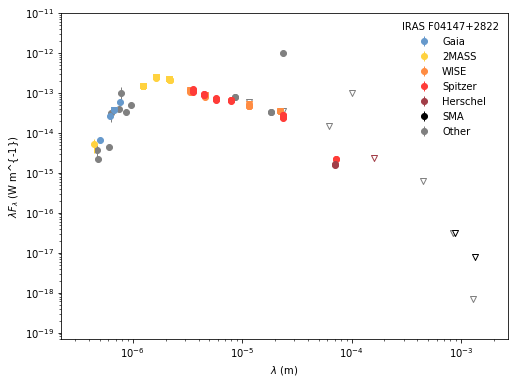

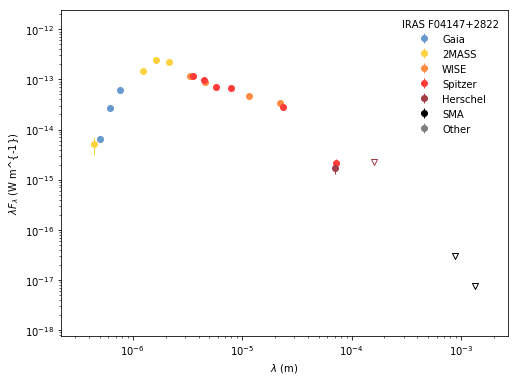

In [21]:
exampleFig=plt.figure(figsize=(8,6)) # just making sure our plot is a good size

examplePlot=plt.gca() # initiallising a matplotlib axes object
SEDBuilder.spectra.plotSED(examplePlot,table) # plotting the data
plt.show() # and displaying it

cleanTable=SEDBuilder.spectra.cleanData(table)
exampleFig=plt.figure(figsize=(8,6)) # just making sure our plot is a good size

examplePlot=plt.gca() # initiallising a matplotlib axes object
SEDBuilder.spectra.plotSED(examplePlot,cleanTable) # plotting the data
plt.show() # and displaying it

In [ ]:
for key in table.meta.keys():
    print(key,': \t\t',table.meta[key])
    #print(table.meta[key])
#print(table.meta)

In [ ]:
saveDir='/Users/Zephyr/Google Drive/astro/pythonModules/SEDBuilder/spectraData'
tmName='J04174965+2829362'
table=SEDBuilder.spectra.addToMetadata(tmName,saveDir,'Hello',1,'me')
#fileTable=SEDBuilder.spectra.getSEDFromFile(tmName,saveDir)
#fileTable=astropy.io.ascii.read('/Users/Zephyr/Google Drive/astro/pythonModules/SEDBuilder/spectraData/J04174965+2829362.ecsv')
#print(fileTable)
#for key in fileTable.meta.keys():
#    print('key: ',key)
#    print(fileTable.meta[key])
#    print(type(fileTable.meta[key]))

In [ ]:
import astroquery.simbad
import astroquery.vizier
simbad=astroquery.simbad.Simbad()
simbad.add_votable_fields('sptype')
simbad.add_votable_fields('ids')
simbad.add_votable_fields('otype')
simbad.add_votable_fields('plx')
simbad.add_votable_fields('plx_bibcode')
star=simbad.query_object(v410)
print(star)
print(star.keys())
print(star['SP_TYPE'])
print(star['SP_BIBCODE'])
spTypeBib=star['SP_BIBCODE']

catalogs=astroquery.vizier.Vizier.find_catalogs(spTypeBib)
print(SEDBuilder.spectra.getRef(spTypeBib))
description=catalogs[list(catalogs.items())[0][0]].description
reference=description[description.rfind('(')+1:description.rfind(')')]
print(catalogs)
print(description)
print(reference)

In [ ]:
astroquery.simbad.Simbad.list_votable_fields()

In [ ]:
import astroquery
astroquery.simbad.Simbad.get_field_description('sp')